# Understanding the Impact of Activation Functions on Deep Learning: A Practical Comparison of ReLU Variants.

### Import Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load dataset 

CSV as data/dry_beans.csv 

In [6]:
data_path = "Dry_bean.csv"  # change if different
df = pd.read_csv(data_path)

df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [8]:
print(df.shape)
print(df.columns)

(13611, 17)
Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')


In [10]:
target_col = "Class"

X = df.drop(columns=[target_col])
y = df[target_col]

print("Features shape:", X.shape)
print("Target sample:", y.unique())

Features shape: (13611, 16)
Target sample: ['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']


### Encode labels & train/val/test split

In [13]:
# Encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=SEED, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print("Train:", X_train_full.shape, y_train_full.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

num_classes = len(np.unique(y_encoded))
input_dim = X_train_full.shape[1]
print("Num features:", input_dim, "| Num classes:", num_classes)

Train: (9527, 16) (9527,)
Val: (2042, 16) (2042,)
Test: (2042, 16) (2042,)
Num features: 16 | Num classes: 7


### Feature scaling

We’ll standardise features for all splits

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_full)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((9527, 16), (2042, 16), (2042, 16))

### Model builder with pluggable activation

#### We’ll compare these linear unit family activations:

#### "relu"

#### "leaky_relu"

#### "elu"

#### "gelu" (Gaussian Error Linear Unit via tf.nn.gelu)

#### The only difference between models: which activation we plug into the hidden layers.

In [19]:
def build_mlp(activation_name, hidden_units=256, num_hidden_layers=3, dropout_rate=0.0):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_units)(x)
        
        if activation_name == "relu":
            x = layers.ReLU()(x)
        elif activation_name == "leaky_relu":
            x = layers.LeakyReLU(alpha=0.1)(x)
        elif activation_name == "elu":
            x = layers.ELU(alpha=1.0)(x)
        elif activation_name == "gelu":
            x = layers.Activation(tf.nn.gelu)(x)
        else:
            # fallback to built-in if you pass something else
            x = layers.Activation(activation_name)(x)
        
        if dropout_rate > 0.0:
            x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name=f"MLP_{activation_name}")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Quick sanity check
test_model = build_mlp("relu")
test_model.summary()

Model: "MLP_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,735 (538.03 KB)

 Trainable params: 137,735 (538.03 KB)

 Non-trainable params: 0 (0.00 B)

### Train one model per activation function

We’ll run each variant for the same number of epochs.

In [22]:
ACTIVATIONS = ["relu", "leaky_relu", "elu", "gelu"]
EPOCHS = 30
BATCH_SIZE = 128

histories = {}
test_results = {}

for act in ACTIVATIONS:
    print(f"\n=== Training with activation: {act} ===")
    model = build_mlp(act, hidden_units=256, num_hidden_layers=3, dropout_rate=0.2)
    
    history = model.fit(
        X_train, y_train_full,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    
    histories[act] = history.history
    
    # Evaluate on test
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    
    test_acc = accuracy_score(y_test, y_pred)
    
    test_results[act] = {
        "accuracy": test_acc
    }
    
    print(f"Test Accuracy ({act}): {test_acc:.4f}")



=== Training with activation: relu ===
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8128 - loss: 0.5476 - val_accuracy: 0.9148 - val_loss: 0.2404
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9099 - loss: 0.2580 - val_accuracy: 0.9192 - val_loss: 0.2171
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9162 - loss: 0.2368 - val_accuracy: 0.9231 - val_loss: 0.2088
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9196 - loss: 0.2215 - val_accuracy: 0.9270 - val_loss: 0.2040
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9246 - loss: 0.2101 - val_accuracy: 0.9261 - val_loss: 0.2008
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9257 - loss: 0.2144 - val_accuracy: 0.9295 - val_loss: 0.2005
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9259 - loss: 0.2043 - val_accuracy: 0.9265 - val_loss: 0.2005
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9250 - loss: 0

D:\Anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8181 - loss: 0.5352 - val_accuracy: 0.9119 - val_loss: 0.2406
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9163 - loss: 0.2402 - val_accuracy: 0.9226 - val_loss: 0.2135
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9199 - loss: 0.2234 - val_accuracy: 0.9236 - val_loss: 0.2030
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9243 - loss: 0.2162 - val_accuracy: 0.9241 - val_loss: 0.2045
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9261 - loss: 0.2077 - val_accuracy: 0.9246 - val_loss: 0.2022
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9257 - loss: 0.2051 - val_accuracy: 0.9275 - val_loss: 0.2001
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9269 - loss: 0.2053 - val_accuracy: 0.9275 - val_loss: 0.1976
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9253 - loss: 0.2026 - val_accuracy: 0.9265 - val_loss: 0.1968
Epo

### Summarise test performance

In [25]:
print("\n=== Test accuracy by activation function ===")
for act, res in test_results.items():
    print(f"{act:10s}: {res['accuracy']:.4f}")


=== Test accuracy by activation function ===
relu      : 0.9236
leaky_relu: 0.9226
elu       : 0.9216
gelu      : 0.9241


### Visualise learning curves
6.1 Accuracy curves

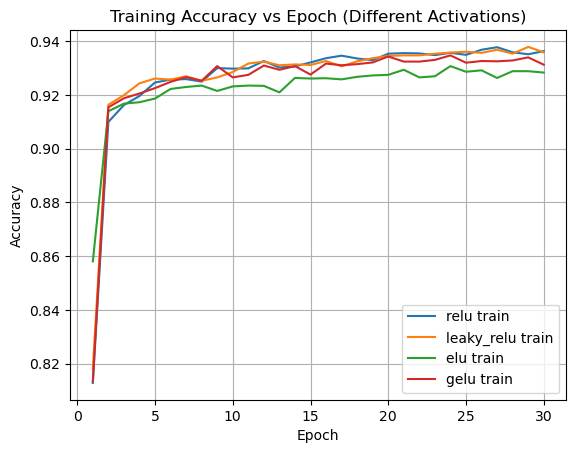

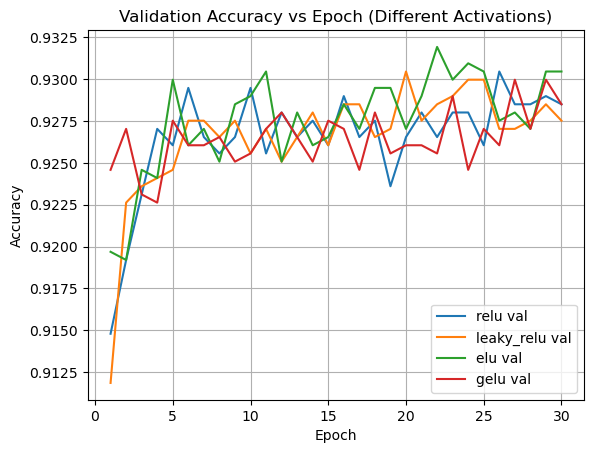

In [33]:
epochs = range(1, EPOCHS + 1)

plt.figure()
for act in ACTIVATIONS:
    plt.plot(epochs, histories[act]["accuracy"], label=f"{act} train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Epoch (Different Activations)")
plt.legend()
plt.grid(True)
plt.savefig("training Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for act in ACTIVATIONS:
    plt.plot(epochs, histories[act]["val_accuracy"], label=f"{act} val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epoch (Different Activations)")
plt.legend()
plt.grid(True)
plt.savefig("Validation Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

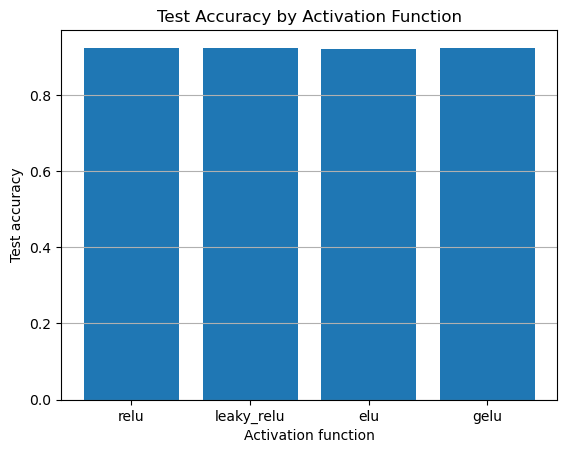

In [35]:
plt.figure()
acts = list(test_results.keys())
accs = [test_results[a]["accuracy"] for a in acts]
plt.bar(acts, accs)
plt.xlabel("Activation function")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy by Activation Function")
plt.grid(axis="y")
plt.savefig("figures/test_accuracy_activations.png", dpi=300, bbox_inches="tight")
plt.show()